In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:


def construct_state_tensor(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        arr = np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))
        return torch.tensor(arr, device=device, dtype=torch.float)
        

    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x), dim=0)

In [115]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(num_inputs, num_actions)
        #print(f'PolicyNetLinear {num_inputs}, {num_actions}')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x), dim=0)
    
class PolicyMonteCarlo(nn.Module):
    def __init__(self, num_guesses, num_actions):
        super(PolicyMonteCarlo, self).__init__()
        self.weights = torch.nn.Parameter(torch.rand((num_guesses, num_actions), dtype=float), requires_grad=True)
        #self.weights.require_grad = True
        self.x = torch.Tensor([1.0,1.0])
        
    def forward(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        
        y = F.softmax(self.x.mul(self.weights[step_idx]), dim=0)
        #print(f'onehot {onehot}, step_idx {step_idx}')
        #print(self.weights)
        #print(self.weights[step_idx])
        #print(y)
        return y
    
class PolicyAvgReward():
    def __init__(self, num_guesses, num_actions):
        #self.weights = torch.Tensor([[.5,.5],[1,0],[1,0],[1,0],[1,0],[1,0]])
        self.weights = torch.rand((num_guesses, num_actions), dtype=float)
        
        self.reward_stats = [(defaultdict(int),defaultdict(int)) for _ in range(num_guesses)]
        self.num_guesses = num_guesses
        self.num_actions = num_actions
        
    def __call__(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        #if step_idx == 0:
        return F.softmax(self.weights[step_idx], dim=0)
        #else:
        #    return self.weights[step_idx]
    
    def calc_avgs(self):
        for action in range(self.num_actions):
            for step_idx in range(self.num_guesses):
                if self.reward_stats[step_idx][action]['count'] > 0:
                    self.weights[step_idx][action] = self.reward_stats[step_idx][action]['total'] / self.reward_stats[step_idx][action]['count']
        

In [116]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        self.actions = [[env.find_target_words, env.find_words_matching_current_history]]
        self.actions.append([env.find_words_with_highest_new_letter_freq_score])
                
        self.num_actions = len(self.actions)
        #self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(self, action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            newdf = tactic(df)
            if not newdf.empty: #if that tactic produced no results, then quit
                df = newdf
        return df.sample()['word'][0] # then pick a random word from what is left
    
    

In [117]:





def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [118]:
def optimize_model_batch(model, optimizer, memory, batch_size=128):
    if batch_size <= 0:
        transitions = memory.memory
    else:
        transitions = memory.sample(batch_size)
    print(f'optimize_model_batch {batch_size} {len(transitions)}')
    losses = [optimize_model_single(model, optimizer, tr.state, tr.action, tr.reward) for tr in transitions]
    
    return losses

optimizations_run = 0

def optimize_model_single(model, optimizer, state, action, reward):
    global optimizations_run
    optimizations_run += 1
    if isinstance(model, PolicyAvgReward):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        model.reward_stats[step_idx][action]['count'] += 1
        model.reward_stats[step_idx][action]['total'] += reward
        model.calc_avgs()
        return reward
    # calculate gradient
    probs = model(state)
    sampler = Categorical(probs)
    #print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action)   # "-" because it was built to work with gradient descent, but we are using gradient ascent

    pseudo_loss = log_probs * reward # loss that when differentiated with autograd gives the gradient of J(θ)
    #print(f'log_prob {log_probs}, reward {reward}, loss {pseudo_loss} ')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    return pseudo_loss


class TrainConfig():
    def __init__(self, optimizer='adam', batch_size=64, train_interval=64, clear_memory=False, lr=0.01):
        self.optimizer = optimizer
        self.clear_memory = clear_memory
        self.lr = lr
        self.train_interval = train_interval
        self.batch_size = batch_size
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [119]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(),
                   seed=0):
    global optimizations_run
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_tensor(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    reward_stats = [(defaultdict(int),defaultdict(int)) for _ in range(env.num_guesses)]
    transitions_added_to_memory = 0
    optimizations_run = 0
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_state_features, len(policy_helper.actions)).to(device)
    elif model.name == 'monte':
        policy_net = PolicyMonteCarlo(env.num_guesses, len(policy_helper.actions)).to(device)
        print('monte weights')
        print(policy_net.weights)
        print(F.softmax(policy_net.weights, dim=1))
    elif model.name == 'avg_reward':
        policy_net = PolicyAvgReward(env.num_guesses, len(policy_helper.actions))
    else:
        policy_net = PolicyNetNN(n_state_features, len(policy_helper.actions)).to(device)
    
    if model.name == 'avg_reward':
        optimizer = None
    elif training.optimizer == 'rmsprop':
            optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    elif training.optimizer == 'sgd':
            optimizer = optim.SGD(policy_net.parameters(), lr=training.lr)
    else:
            optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)

        #print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(chosen_word)
            print(f'------guess {t} {action_idx} {guesses[-1]}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_tensor(guesses, history)
            
            #action_tensor = action_idx.clone().detach()
            action = action_idx #F.one_hot(action_idx, num_classes=policy_helper.num_actions)
                
            print(f'reward {reward} done {done} action {action}')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for idx,tr in enumerate(episode_memory):
                    #print(f'pushing episode_reward {episode_reward} {episode_reward.__class__}')
                    transitions_added_to_memory += 1
                    memory.push(tr[0], tr[1], episode_reward)
                    #loss = optimize_model_single(policy_net, optimizer, tr[0], tr[1], episode_reward)
                    #losses.append(loss)
                
                    reward_stats[idx][tr[1]]['count'] += 1
                    reward_stats[idx][tr[1]]['total'] += episode_reward
                    episode_reward -= tr[2]
                    
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= max(1,training.batch_size) \
                    and i_episode % training.train_interval == 0:
                    losses += optimize_model_batch(policy_net, optimizer, memory, batch_size=training.batch_size)
                    if training.clear_memory: memory.clear()
                        
                    if model.name == 'monte':
                        print('monte weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                        for rs in reward_stats:
                            if rs[0]['count'] > 0:
                                rs[0]['avg'] = rs[0]['total'] / rs[0]['count']
                            if rs[1]['count'] > 0:
                                rs[1]['avg'] = rs[1]['total'] / rs[1]['count']
                            print(dict(rs[0]), dict(rs[1]))
                    elif model.name == 'avg_reward':
                        print('monte weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                        for rs in policy_net.reward_stats:
                            if rs[0]['count'] > 0:
                                rs[0]['avg'] = rs[0]['total'] / rs[0]['count']
                            if rs[1]['count'] > 0:
                                rs[1]['avg'] = rs[1]['total'] / rs[1]['count']
                            print(dict(rs[0]), dict(rs[1]))
                    print(f'done {optimizations_run} optimizations, {transitions_added_to_memory} transitions added to memory')
                    
                        
                        
                
                #plot_durations()
                break

    print('Complete')
    
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

In [104]:
plot_all(*run_experiment(
    model=ModelConfig(name='avg_reward'),
    num_episodes=500,
    training=TrainConfig(optimizer='sgd', lr=0.01, batch_size=-1, train_interval=8, clear_memory=True),
    seed=1
    ))

=========================episode 0 nanny======================
------guess 0 0 spied-------
reward -1 done False action 0
------guess 1 0 manly-------
reward -1 done False action 0
------guess 2 0 fanny-------
reward -1 done False action 0
------guess 3 0 canny-------
reward -1 done False action 0
------guess 4 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.019801326693244747  steps 5  memory 0
optimize_model_batch -1 5
monte weights
tensor([[0.5000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000]])
tensor([[0.5000, 0.5000],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689]])
{'count': 1, 'total': -4, 'avg': -4.0} {'count': 0}
{'count': 1, 'total': -3, 'avg': -3.0} {'count': 0}
{'count': 1, 'total': -2, 'avg': -2.0} {'count': 0}
{'count': 1, 'total': -1, 'avg': -

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 judge-------
reward -1 done False action 0
------guess 2 0 mince-------
reward -1 done False action 0
------guess 3 0 whine-------
reward 0 done True action 0
episode 17 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3092656693626453  steps 75  memory 0
=========================episode 18 steep======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 thief-------
reward -1 done False action 0
------guess 2 0 unset-------
reward -1 done False action 0
------guess 3 0 steel-------
reward -1 done False action 0
------guess 4 0 steed-------
reward -1 done False action 0
------guess 5 0 steep-------
reward 0 done True action 0
episode 18 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.3296799539643607  steps 81  memory 4
=========================episode 19 zonal======================
------guess 0 0 limbo-------
reward -1 done False action 0
------guess 1 0 offal------

------guess 3 0 saint-------
reward 0 done True action 0
episode 34 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.500925552014864  steps 140  memory 4
=========================episode 35 deign======================
------guess 0 0 baron-------
reward -1 done False action 0
------guess 1 0 hymen-------
reward -1 done False action 0
------guess 2 0 elfin-------
reward -1 done False action 0
------guess 3 0 deign-------
reward 0 done True action 0
episode 35 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5108078882036684  steps 144  memory 8
=========================episode 36 elite======================
------guess 0 0 glade-------
reward -1 done False action 0
------guess 1 0 close-------
reward -1 done False action 0
------guess 2 0 fluke-------
reward -1 done False action 0
------guess 3 0 elite-------
reward 0 done True action 0
episode 36 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5204945410251058  steps 148  memory 12
=========================episode 37 rabbi===

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 worth-------
reward -1 done False action 0
------guess 2 0 forth-------
reward -1 done False action 0
------guess 3 0 north-------
reward 0 done True action 0
episode 51 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.6518075726938024  steps 212  memory 9
=========================episode 52 villa======================
------guess 0 0 theta-------
reward -1 done False action 0
------guess 1 0 pizza-------
reward -1 done False action 0
------guess 2 0 villa-------
reward 0 done True action 0
episode 52 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.6569914825812934  steps 215  memory 13
=========================episode 53 metro======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 voter-------
reward -1 done False action 0
------guess 2 0 retro-------
reward -1 done False action 0
------guess 3 0 metro-------
reward 0 done True action 0
episode 53 finished.  rewa

------guess 1 0 scent-------
reward -1 done False action 0
------guess 2 0 squat-------
reward -1 done False action 0
------guess 3 0 shoot-------
reward 0 done True action 0
episode 68 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7458930404471997  steps 275  memory 13
=========================episode 69 manly======================
------guess 0 0 among-------
reward -1 done False action 0
------guess 1 0 human-------
reward -1 done False action 0
------guess 2 0 manly-------
reward 0 done True action 0
episode 69 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7496762002083039  steps 278  memory 17
=========================episode 70 shall======================
------guess 0 0 clear-------
reward -1 done False action 0
------guess 1 0 afoul-------
reward -1 done False action 0
------guess 2 0 shall-------
reward 0 done True action 0
episode 70 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7534030360583935  steps 281  memory 20
=========================episode 71 derby

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 briar-------
reward -1 done False action 0
------guess 2 0 flair-------
reward -1 done False action 0
------guess 3 0 chair-------
reward 0 done True action 0
episode 85 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8191342073828779  steps 343  memory 20
=========================episode 86 repay======================
------guess 0 0 alike-------
reward -1 done False action 0
------guess 1 0 heath-------
reward -1 done False action 0
------guess 2 0 vegan-------
reward -1 done False action 0
------guess 3 0 debar-------
reward -1 done False action 0
------guess 4 0 recap-------
reward -1 done False action 0
------guess 5 0 repay-------
reward 0 done True action 0
episode 86 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8244795993830032  steps 349  memory 24
=========================episode 87 ridge======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 eerie--

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 prism-------
reward -1 done False action 0
------guess 2 0 drunk-------
reward 0 done True action 0
episode 103 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8712650964121957  steps 411  memory 22
=========================episode 104 cadet======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 facet-------
reward -1 done False action 0
------guess 2 0 cadet-------
reward 0 done True action 0
episode 104 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8731817094320049  steps 414  memory 25
optimize_model_batch -1 28
monte weights
tensor([[0.5000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000]])
tensor([[0.5000, 0.5000],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689]])
{'count': 58, 'total': -

------guess 2 0 verso-------
reward 0 done True action 0
episode 121 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9065192737219415  steps 475  memory 0
=========================episode 122 ideal======================
------guess 0 0 chunk-------
reward -1 done False action 0
------guess 1 0 rigor-------
reward -1 done False action 0
------guess 2 0 swill-------
reward -1 done False action 0
------guess 3 0 impel-------
reward -1 done False action 0
------guess 4 0 ideal-------
reward 0 done True action 0
episode 122 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9088273210774022  steps 480  memory 3
=========================episode 123 shown======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 smoky-------
reward -1 done False action 0
------guess 2 0 swoop-------
reward -1 done False action 0
------guess 3 0 shown-------
reward 0 done True action 0
episode 123 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9106326610782468  

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 penne-------
reward -1 done False action 0
------guess 2 0 lunge-------
reward -1 done False action 0
------guess 3 0 binge-------
reward -1 done False action 0
------guess 4 0 hinge-------
reward -1 done False action 0
------guess 5 0 singe-------
reward 0 done True action 0
episode 139 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9354296531068316  steps 549  memory 10
=========================episode 140 proof======================
------guess 0 0 welch-------
reward -1 done False action 0
------guess 1 0 guppy-------
reward -1 done False action 0
------guess 2 0 spank-------
reward -1 done False action 0
------guess 3 0 pivot-------
reward -1 done False action 0
------guess 4 0 proof-------
reward 0 done True action 0
episode 140 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9370239006519849  steps 554  memory 16
=========================episode 141 imply======================
------guess 0 1 ora

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 sound-------
reward -1 done False action 0
------guess 2 0 cough-------
reward -1 done False action 0
------guess 3 0 couch-------
reward 0 done True action 0
episode 155 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9538103716183199  steps 616  memory 9
=========================episode 156 grape======================
------guess 0 0 wedge-------
reward -1 done False action 0
------guess 1 0 agate-------
reward -1 done False action 0
------guess 2 0 glaze-------
reward -1 done False action 0
------guess 3 0 grave-------
reward -1 done False action 0
------guess 4 0 grace-------
reward -1 done False action 0
------guess 5 0 grape-------
reward 0 done True action 0
episode 156 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9551754814407332  steps 622  memory 13
=========================episode 157 magic======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 papa

------guess 2 0 oddly-------
reward 0 done True action 0
episode 172 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9677745897680832  steps 688  memory 13
=========================episode 173 story======================
------guess 0 0 first-------
reward -1 done False action 0
------guess 1 0 stern-------
reward -1 done False action 0
------guess 2 0 storm-------
reward -1 done False action 0
------guess 3 0 story-------
reward 0 done True action 0
episode 173 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9684126956439092  steps 692  memory 16
=========================episode 174 dingo======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 limbo-------
reward -1 done False action 0
------guess 2 0 hippo-------
reward -1 done False action 0
------guess 3 0 dingo-------
reward 0 done True action 0
episode 174 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9690381661768231  steps 696  memory 20
=========================episode 175

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 trade-------
reward -1 done False action 0
------guess 2 0 trace-------
reward 0 done True action 0
episode 190 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.977062909358071  steps 756  memory 19
=========================episode 191 check======================
------guess 0 0 krill-------
reward -1 done False action 0
------guess 1 0 shook-------
reward -1 done False action 0
------guess 2 0 whack-------
reward -1 done False action 0
------guess 3 0 chuck-------
reward -1 done False action 0
------guess 4 0 check-------
reward 0 done True action 0
episode 191 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9776292281438344  steps 761  memory 22
=========================episode 192 warty======================
------guess 0 0 fuzzy-------
reward -1 done False action 0
------guess 1 0 parry-------
reward -1 done False action 0
------guess 2 0 tardy-------
reward -1 done False action 0
------guess 3 0 wart

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 halve-------
reward -1 done False action 0
------guess 2 0 amuse-------
reward 0 done True action 0
episode 207 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.983674059590559  steps 824  memory 27
=========================episode 208 husky======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 spiny-------
reward -1 done False action 0
------guess 2 0 musky-------
reward -1 done False action 0
------guess 3 0 husky-------
reward 0 done True action 0
episode 208 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9839973348701808  steps 828  memory 30
optimize_model_batch -1 34
monte weights
tensor([[0.5000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000]])
tensor([[0.5000, 0.5000],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.

------guess 2 0 scoop-------
reward -1 done False action 0
------guess 3 0 spoof-------
reward -1 done False action 0
------guess 4 0 spoon-------
reward -1 done False action 0
------guess 5 0 spook-------
reward 0 done True action 0
episode 225 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9886097778754867  steps 896  memory 0
=========================episode 226 talon======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 taboo-------
reward -1 done False action 0
------guess 2 0 talon-------
reward 0 done True action 0
episode 226 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9887793561904109  steps 899  memory 6
=========================episode 227 alone======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 above-------
reward -1 done False action 0
------guess 2 0 awoke-------
reward -1 done False action 0
------guess 3 0 anode-------
reward -1 done False action 0
------guess 4 0 alone

------guess 1 0 crypt-------
reward -1 done False action 0
------guess 2 0 layer-------
reward -1 done False action 0
------guess 3 0 flyer-------
reward 0 done True action 0
episode 242 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9920929459484066  steps 969  memory 4
=========================episode 243 fiend======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 spied-------
reward -1 done False action 0
------guess 2 0 yield-------
reward -1 done False action 0
------guess 3 0 fiend-------
reward 0 done True action 0
episode 243 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9922495161088634  steps 973  memory 8
=========================episode 244 robin======================
------guess 0 0 rigid-------
reward -1 done False action 0
------guess 1 0 relic-------
reward -1 done False action 0
------guess 2 0 ratio-------
reward -1 done False action 0
------guess 3 0 robin-------
reward 0 done True action 0
episode 244 finished.  

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 couch-------
reward -1 done False action 0
------guess 2 0 limbo-------
reward -1 done False action 0
------guess 3 0 dingo-------
reward 0 done True action 0
episode 259 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9943437830860469  steps 1036  memory 7
=========================episode 260 sneak======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 navel-------
reward -1 done False action 0
------guess 2 0 sedan-------
reward -1 done False action 0
------guess 3 0 sneak-------
reward 0 done True action 0
episode 260 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.994455783685008  steps 1040  memory 11
=========================episode 261 puffy======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 bushy-------
reward -1 done False action 0
------guess 2 0 dumpy-------
reward -1 done False action 0
------guess 3 0 puf

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 tasty-------
reward -1 done False action 0
------guess 2 0 amity-------
reward -1 done False action 0
------guess 3 0 aunty-------
reward 0 done True action 0
episode 276 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9959336114191201  steps 1102  memory 13
=========================episode 277 cavil======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 gawky-------
reward -1 done False action 0
------guess 2 0 basic-------
reward -1 done False action 0
------guess 3 0 cavil-------
reward 0 done True action 0
episode 277 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9960141313078718  steps 1106  memory 17
=========================episode 278 showy======================
------guess 0 0 towel-------
reward -1 done False action 0
------guess 1 0 arrow-------
reward -1 done False action 0
------guess 2 0 owing-------
reward -1 done False action 0
------guess 3 0 s

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 aisle-------
reward 0 done True action 0
episode 294 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9970911573741874  steps 1169  memory 20
=========================episode 295 blind======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 fishy-------
reward -1 done False action 0
------guess 2 0 pupil-------
reward -1 done False action 0
------guess 3 0 clink-------
reward -1 done False action 0
------guess 4 0 blind-------
reward 0 done True action 0
episode 295 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9971629769545145  steps 1174  memory 22
=========================episode 296 exist======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 sweet-------
reward -1 done False action 0
------guess 2 0 upset-------
reward -1 done False action 0
------guess 3 0 heist-------
reward -1 done False action 0
------guess 4 0 e

------guess 3 0 stake-------
reward 0 done True action 0
episode 310 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9978877467282673  steps 1233  memory 22
=========================episode 311 gloss======================
------guess 0 0 neigh-------
reward -1 done False action 0
------guess 1 0 groom-------
reward -1 done False action 0
------guess 2 0 gloat-------
reward -1 done False action 0
------guess 3 0 gloss-------
reward 0 done True action 0
episode 311 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9979295721453597  steps 1237  memory 26
=========================episode 312 polka======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 vodka-------
reward -1 done False action 0
------guess 2 0 polka-------
reward 0 done True action 0
episode 312 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9979603968003071  steps 1240  memory 30
optimize_model_batch -1 33
monte weights
tensor([[0.5000, 0.5000],
        [1.0000, 0.0000],

KeyboardInterrupt: 

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 gaudy-------
reward -1 done False action 0
------guess 2 0 balmy-------
reward -1 done False action 0
------guess 3 0 happy-------
reward -1 done False action 0
------guess 4 1 snick-------
reward -1 done False action 1
------guess 5 0 fanny-------
reward -1 done True action 0
episode 0 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
optimize_model_batch -1 6
monte weights
tensor([[ 0.0611, -6.0000],
        [-5.0000,  0.1771],
        [-4.0000,  0.1094],
        [-3.0000,  0.7084],
        [ 0.5798, -2.0000],
        [-1.0000,  0.3295]], dtype=torch.float64)
tensor([[0.9977, 0.0023],
        [0.0056, 0.9944],
        [0.0162, 0.9838],
        [0.0239, 0.9761],
        [0.9295, 0.0705],
        [0.2092, 0.7908]], dtype=torch.float64)
{'count': 0} {'count': 1, 'total': -6, 'avg': -6.0}
{'count': 1, 'total': -5

------guess 1 1 stoai-------
reward -1 done False action 1
------guess 2 1 dunch-------
reward -1 done False action 1
------guess 3 1 gamps-------
reward -1 done False action 1
------guess 4 0 hunch-------
reward -1 done False action 0
------guess 5 1 bawks-------
reward -1 done True action 1
episode 16 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.36237184837822667  steps 91  memory 79
optimize_model_batch -1 85
monte weights
tensor([[-4.5625, -6.0000],
        [-5.0000, -3.5625],
        [-4.0000, -2.5625],
        [-3.0000, -1.5625],
        [-0.5625, -2.0000],
        [-0.5000, -1.0000]], dtype=torch.float64)
tensor([[0.8081, 0.1919],
        [0.1919, 0.8081],
        [0.1919, 0.8081],
        [0.1919, 0.8081],
        [0.8081, 0.1919],
        [0.6225, 0.3775]], dtype=torch.float64)
{'count': 16, 'total': -73, 'avg': -4.5625} {'count': 1, 'total': -6, 'avg': -6.0}
{'count': 1, 'total': -5, 'avg': -5.0} {'count': 16, 'total': -57, 'avg': -3.5625}
{'count': 1, 'total': -4, 'av

------guess 5 1 vezir-------
reward -1 done True action 1
episode 31 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5661255185670091  steps 168  memory 71
=========================episode 32 slink======================
------guess 0 0 ovine-------
reward -1 done False action 0
------guess 1 1 slart-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 1 grump-------
reward -1 done False action 1
------guess 4 0 slink-------
reward 0 done True action 0
episode 32 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5768379176822511  steps 173  memory 77
optimize_model_batch -1 82
monte weights
tensor([[-4.3871, -5.5000],
        [-3.3333, -3.4815],
        [-4.0000, -2.3548],
        [-1.3333, -1.4667],
        [-0.3793, -1.6667],
        [-0.3333, -1.0000]], dtype=torch.float64)
tensor([[0.7527, 0.2473],
        [0.5370, 0.4630],
        [0.1618, 0.8382],
        [0.5333, 0.4667],
        [0.7837, 0.2163],
        [0.6608, 0.3

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 pushy-------
reward -1 done False action 0
------guess 3 1 medic-------
reward -1 done False action 1
------guess 4 0 musky-------
reward 0 done True action 0
episode 50 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.7134952031398099  steps 251  memory 3
=========================episode 51 defer======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 lever-------
reward -1 done False action 0
------guess 2 1 incus-------
reward -1 done False action 1
------guess 3 1 hyped-------
reward -1 done False action 1
------guess 4 0 defer-------
reward 0 done True action 0
episode 51 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.7205690317785927  steps 256  memory 8
=========================episode 52 scuba======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 palsy----

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 pulpy-------
reward -1 done False action 0
------guess 2 1 chins-------
reward -1 done False action 1
------guess 3 1 madge-------
reward -1 done False action 1
------guess 4 0 finch-------
reward -1 done False action 0
------guess 5 1 bawks-------
reward -1 done True action 1
episode 67 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.8060199577091081  steps 329  memory 10
=========================episode 68 lodge======================
------guess 0 0 genie-------
reward -1 done False action 0
------guess 1 0 fugue-------
reward -1 done False action 0
------guess 2 0 badge-------
reward -1 done False action 0
------guess 3 0 lodge-------
reward 0 done True action 0
episode 68 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8098610198984795  steps 333  memory 16
=========================episode 69 quart======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-

------guess 4 0 hunch-------
reward -1 done False action 0
------guess 5 0 munch-------
reward 0 done True action 0
episode 83 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8680061568121697  steps 406  memory 10
=========================episode 84 purge======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 spire-------
reward -1 done False action 0
------guess 2 1 lunch-------
reward -1 done False action 1
------guess 3 0 purge-------
reward 0 done True action 0
episode 84 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8706198100226289  steps 410  memory 16
=========================episode 85 tryst======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 tryst-------
reward 0 done True action 0
episode 85 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8725460301051793  steps 413  memory 20
=========================episode 86 tiara

------guess 1 1 reoil-------
reward -1 done False action 1
------guess 2 0 unset-------
reward 0 done True action 0
episode 101 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9083703161224952  steps 479  memory 14
=========================episode 102 guess======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 beefy-------
reward -1 done False action 0
------guess 2 1 linds-------
reward -1 done False action 1
------guess 3 0 chess-------
reward -1 done False action 0
------guess 4 0 guess-------
reward 0 done True action 0
episode 102 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9106326610782468  steps 484  memory 17
=========================episode 103 bitty======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 sixty-------
reward -1 done False action 0
------guess 2 0 kitty-------
reward -1 done False action 0
------guess 3 1 lunch-------
reward -1 done False action 1
------guess 4 0 bit

------guess 1 0 rumor-------
reward -1 done False action 0
------guess 2 0 limit-------
reward -1 done False action 0
------guess 3 0 dimly-------
reward 0 done True action 0
episode 118 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9382709109690412  steps 558  memory 24
=========================episode 119 wrath======================
------guess 0 0 brash-------
reward -1 done False action 0
------guess 1 1 teloi-------
reward -1 done False action 1
------guess 2 0 wrath-------
reward 0 done True action 0
episode 119 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9391899373747821  steps 561  memory 28
=========================episode 120 mucky======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 mucky-------
reward 0 done True action 0
episode 120 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9403940572910606

------guess 3 0 bused-------
reward 0 done True action 0
episode 135 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9567172020980341  steps 629  memory 29
=========================episode 136 femur======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 lemur-------
reward -1 done False action 0
------guess 2 1 chins-------
reward -1 done False action 1
------guess 3 1 podgy-------
reward -1 done False action 1
------guess 4 0 femur-------
reward 0 done True action 0
episode 136 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9577858581858936  steps 634  memory 33
=========================episode 137 oaken======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 ocean-------
reward -1 done False action 0
------guess 2 0 oaken-------
reward 0 done True action 0
episode 137 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9584143448788268  steps 637  memory 38
=========================episode 138

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 exist-------
reward 0 done True action 0
episode 154 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.970400564832108  steps 705  memory 37
=========================episode 155 aptly======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 tally-------
reward -1 done False action 0
------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 0 aptly-------
reward 0 done True action 0
episode 155 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9711313774903149  steps 710  memory 41
=========================episode 156 owner======================
------guess 0 0 phase-------
reward -1 done False action 0
------guess 1 0 newer-------
reward -1 done False action 0
------guess 2 0 owne

------guess 4 1 peghs-------
reward -1 done False action 1
------guess 5 0 pride-------
reward 0 done True action 0
episode 172 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9795546539620623  steps 779  memory 47
=========================episode 173 deity======================
------guess 0 0 match-------
reward -1 done False action 0
------guess 1 0 forte-------
reward -1 done False action 0
------guess 2 0 piety-------
reward -1 done False action 0
------guess 3 0 deity-------
reward 0 done True action 0
episode 173 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.979959498938316  steps 783  memory 53
=========================episode 174 aunty======================
------guess 0 0 crash-------
reward -1 done False action 0
------guess 1 1 toile-------
reward -1 done False action 1
------guess 2 0 aunty-------
reward 0 done True action 0
episode 174 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9802578631285073  steps 786  memory 57
=========================episode 175 

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 karma-------
reward -1 done False action 0
------guess 2 0 briar-------
reward -1 done False action 0
------guess 3 1 shuln-------
reward -1 done False action 1
------guess 4 0 lunar-------
reward 0 done True action 0
episode 190 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9861573379135204  steps 857  memory 57
=========================episode 191 sandy======================
------guess 0 0 worth-------
reward -1 done False action 0
------guess 1 0 plank-------
reward -1 done False action 0
------guess 2 0 naive-------
reward -1 done False action 0
------guess 3 1 dumbs-------
reward -1 done False action 1
------guess 4 0 sandy-------
reward 0 done True action 0
episode 191 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9864991144581977  steps 862  memory 62
=========================episode 192 grime======================
------guess 0 0 pizza-------
reward -1 done False action 0
------guess 1 0 thi

------guess 2 0 folio-------
reward -1 done False action 0
------guess 3 0 relic-------
reward 0 done True action 0
episode 208 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9904860867580364  steps 932  memory 60
optimize_model_batch -1 64
monte weights
tensor([[-3.7706, -3.3000],
        [-2.4608, -2.6262],
        [-1.2039, -2.0808],
        [-0.6044, -1.4533],
        [-0.3059, -1.3043],
        [-0.1304, -1.0000]], dtype=torch.float64)
tensor([[0.3845, 0.6155],
        [0.5413, 0.4587],
        [0.7062, 0.2938],
        [0.7003, 0.2997],
        [0.7308, 0.2692],
        [0.7047, 0.2953]], dtype=torch.float64)
{'count': 109, 'total': -411, 'avg': -3.770642201834862} {'count': 100, 'total': -330, 'avg': -3.3}
{'count': 102, 'total': -251, 'avg': -2.4607843137254903} {'count': 107, 'total': -281, 'avg': -2.6261682242990654}
{'count': 103, 'total': -124, 'avg': -1.203883495145631} {'count': 99, 'total': -206, 'avg': -2.080808080808081}
{'count': 91, 'total': -55, 'avg': -0.60439

------guess 1 1 aloes-------
reward -1 done False action 1
------guess 2 0 weird-------
reward -1 done False action 0
------guess 3 0 revue-------
reward -1 done False action 0
------guess 4 1 bhang-------
reward -1 done False action 1
------guess 5 0 merge-------
reward 0 done True action 0
episode 226 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9933290966937447  steps 1003  memory 3
=========================episode 227 mania======================
------guess 0 0 fishy-------
reward -1 done False action 0
------guess 1 0 twirl-------
reward -1 done False action 0
------guess 2 0 inane-------
reward -1 done False action 0
------guess 3 0 admin-------
reward -1 done False action 0
------guess 4 0 mania-------
reward 0 done True action 0
episode 227 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9934938018832267  steps 1008  memory 9
=========================episode 228 knack======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lys

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 masse-------
reward 0 done True action 0
episode 244 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9953458686897168  steps 1075  memory 15
=========================episode 245 rodeo======================
------guess 0 0 throw-------
reward -1 done False action 0
------guess 1 0 radio-------
reward -1 done False action 0
------guess 2 0 rodeo-------
reward 0 done True action 0
episode 245 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9954151596777595  steps 1078  memory 18
=========================episode 246 fancy======================
------guess 0 0 elide-------
reward -1 done False action 0
------guess 1 0 baron-------
reward -1 done False action 0
------guess 2 1 chuts-------
reward -1 done False action 1
------guess 3 1 pigmy-------
reward -1 done False action 1
------guess 4 0 fancy-------
reward 0 done True action 0
episode 246 finishe

------guess 2 0 medic-------
reward -1 done False action 0
------guess 3 0 equip-------
reward 0 done True action 0
episode 260 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9968172192034903  steps 1151  memory 15
=========================episode 261 draft======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 tract-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 0 graft-------
reward -1 done False action 0
------guess 4 1 bumph-------
reward -1 done False action 1
------guess 5 1 kawed-------
reward -1 done True action 1
episode 261 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9969112845917633  steps 1157  memory 19
=========================episode 262 askew======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 pedal-------
reward -1 done False action 0
------guess 2 0 annex-------
reward -1 done False action 0
------guess 3 1 

------guess 5 0 bingo-------
reward 0 done True action 0
episode 278 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9978234190392848  steps 1227  memory 19
=========================episode 279 title======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 setup-------
reward -1 done False action 0
------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 0 title-------
reward 0 done True action 0
episode 279 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9978665182299623  steps 1231  memory 25
=========================episode 280 theta======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 least-------
reward -1 done False action 0
------guess 2 0 acute-------
reward -1 done False action 0
------guess 3 0 theta-------
reward 0 done True action 0
episode 280 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9979087639994849  steps 1235  memory 29
=========================episode 

------guess 2 1 synch-------
reward -1 done False action 1
------guess 3 0 rinse-------
reward 0 done True action 0
episode 297 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9984507742670728  steps 1295  memory 26
=========================episode 298 elbow======================
------guess 0 0 swish-------
reward -1 done False action 0
------guess 1 1 orate-------
reward -1 done False action 1
------guess 2 1 clung-------
reward -1 done False action 1
------guess 3 0 elbow-------
reward 0 done True action 0
episode 298 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9984814509919321  steps 1299  memory 30
=========================episode 299 trick======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 trick-------
reward 0 done True action 0
episode 299 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.99851152027694

------guess 1 0 wager-------
reward -1 done False action 0
------guess 2 1 tonic-------
reward -1 done False action 1
------guess 3 0 azure-------
reward -1 done False action 0
------guess 4 0 dream-------
reward -1 done False action 0
------guess 5 0 bread-------
reward 0 done True action 0
episode 315 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9989298966003604  steps 1369  memory 38
=========================episode 316 aphid======================
------guess 0 0 ebony-------
reward -1 done False action 0
------guess 1 1 liart-------
reward -1 done False action 1
------guess 2 1 chums-------
reward -1 done False action 1
------guess 3 0 aphid-------
reward 0 done True action 0
episode 316 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9989510860673723  steps 1373  memory 44
=========================episode 317 harsh======================
------guess 0 0 large-------
reward -1 done False action 0
------guess 1 0 tardy-------
reward -1 done False action 0
------guess 2 0 b

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 chime-------
reward 0 done True action 0
episode 333 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9992608428445372  steps 1443  memory 49
=========================episode 334 title======================
------guess 0 0 bluff-------
reward -1 done False action 0
------guess 1 1 oater-------
reward -1 done False action 1
------guess 2 0 title-------
reward 0 done True action 0
episode 334 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9992718474609106  steps 1446  memory 53
=========================episode 335 clean======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 lease-------
reward -1 done False action 0
------guess 2 0 bleak-------
reward -1 done False action 0
------guess 3 1 cumin-------
reward -1 done False action 1
------guess 4 0 clean-------
reward 0 done True action 0
episode 335 finishe

------guess 3 1 duply-------
reward -1 done False action 1
------guess 4 0 sweet-------
reward 0 done True action 0
episode 351 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9994843075513876  steps 1515  memory 56
=========================episode 352 pansy======================
------guess 0 0 algae-------
reward -1 done False action 0
------guess 1 1 tiros-------
reward -1 done False action 1
------guess 2 0 scamp-------
reward -1 done False action 0
------guess 3 0 pansy-------
reward 0 done True action 0
episode 352 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9994945189460358  steps 1519  memory 61
optimize_model_batch -1 65
monte weights
tensor([[-3.5057, -3.2291],
        [-2.2905, -2.4425],
        [-1.1357, -1.9496],
        [-0.5244, -1.4216],
        [-0.2373, -1.2973],
        [-0.0857, -1.0000]], dtype=torch.float64)
tensor([[0.4313, 0.5687],
        [0.5379, 0.4621],
        [0.6930, 0.3070],
        [0.7104, 0.2896],
        [0.7427, 0.2573],
        [0.7139,

------guess 1 1 loans-------
reward -1 done False action 1
------guess 2 0 shalt-------
reward -1 done False action 0
------guess 3 0 stall-------
reward -1 done False action 0
------guess 4 0 stalk-------
reward 0 done True action 0
episode 370 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9996525882909785  steps 1594  memory 4
=========================episode 371 plunk======================
------guess 0 0 death-------
reward -1 done False action 0
------guess 1 0 silly-------
reward -1 done False action 0
------guess 2 1 cornu-------
reward -1 done False action 1
------guess 3 1 gompa-------
reward -1 done False action 1
------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 0 plunk-------
reward 0 done True action 0
episode 371 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9996628558586775  steps 1600  memory 9
=========================episode 372 fight======================
------guess 0 0 glove-------
reward -1 done False action 0
------guess 1 1 rai

------guess 2 0 chart-------
reward 0 done True action 0
episode 389 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999761227657063  steps 1669  memory 16
=========================episode 390 tenor======================
------guess 0 0 gamut-------
reward -1 done False action 0
------guess 1 1 oriel-------
reward -1 done False action 1
------guess 2 1 synch-------
reward -1 done False action 1
------guess 3 1 bipod-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 1 avyze-------
reward -1 done True action 1
episode 390 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9997682844462619  steps 1675  memory 19
=========================episode 391 level======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 guess-------
reward -1 done False action 0
------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 1 dumpy-------
reward -1 done False action 1
------guess 4 0 l

------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 1 hyped-------
reward -1 done False action 1
------guess 4 0 eclat-------
reward 0 done True action 0
episode 405 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998383375437745  steps 1747  memory 18
=========================episode 406 speed======================
------guess 0 0 femme-------
reward -1 done False action 0
------guess 1 1 tolar-------
reward -1 done False action 1
------guess 2 0 sweep-------
reward -1 done False action 0
------guess 3 1 cuing-------
reward -1 done False action 1
------guess 4 0 speed-------
reward 0 done True action 0
episode 406 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998423290040405  steps 1752  memory 23
=========================episode 407 axiom======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 shoal-------
reward -1 done False action 0
------guess 2 1 cumin-------
reward -1 done False action 1
------guess 3 1 p

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 stake-------
reward -1 done False action 0
------guess 3 0 tease-------
reward 0 done True action 0
episode 423 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998916344149007  steps 1827  memory 27
=========================episode 424 shock======================
------guess 0 0 blimp-------
reward -1 done False action 0
------guess 1 0 squad-------
reward -1 done False action 0
------guess 2 0 sooth-------
reward -1 done False action 0
------guess 3 0 shorn-------
reward -1 done False action 0
------guess 4 1 gryce-------
reward -1 done False action 1
------guess 5 0 shock-------
reward 0 done True action 0
episode 424 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.99989483710195  steps 1833  memory 31
=========================episode 425 chart======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 tra

------guess 1 0 faint-------
reward -1 done False action 0
------guess 2 0 saint-------
reward -1 done False action 0
------guess 3 1 curly-------
reward -1 done False action 1
------guess 4 1 bumph-------
reward -1 done False action 1
------guess 5 0 paint-------
reward 0 done True action 0
episode 441 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999273603760076  steps 1907  memory 35
=========================episode 442 lodge======================
------guess 0 0 lasso-------
reward -1 done False action 0
------guess 1 1 nitre-------
reward -1 done False action 1
------guess 2 0 lodge-------
reward 0 done True action 0
episode 442 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999284418391168  steps 1910  memory 41
=========================episode 443 equip======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 seven-------
reward -1 done False action 0
------guess 2 0 bicep-------
reward -1 done False action 0
------guess 3 0 e

------guess 4 1 cushy-------
reward -1 done False action 1
------guess 5 0 aside-------
reward 0 done True action 0
episode 458 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999495738163034  steps 1980  memory 40
=========================episode 459 parry======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 array-------
reward -1 done False action 0
------guess 3 0 harry-------
reward -1 done False action 0
------guess 4 0 carry-------
reward -1 done False action 0
------guess 5 0 marry-------
reward -1 done True action 0
episode 459 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9999510641352577  steps 1986  memory 46
=========================episode 460 booze======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 vogue-------
reward -1 done False action 0
------guess 3 1 

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 wacky-------
reward -1 done False action 0
------guess 3 0 bawdy-------
reward 0 done True action 0
episode 477 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999668676363668  steps 2064  memory 52
=========================episode 478 billy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 billy-------
reward 0 done True action 0
episode 478 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999675237011232  steps 2068  memory 56
=========================episode 479 spoil======================
------guess 0 0 duvet-------
reward -1 done False action 0
------guess 1 0 morph-------
reward -1 done False action 0
------guess 2 0 spoil-------
reward 0 done True action 0
episode 479 finishe

------guess 1 0 kappa-------
reward -1 done False action 0
------guess 2 0 clank-------
reward -1 done False action 0
------guess 3 1 murid-------
reward -1 done False action 1
------guess 4 0 frank-------
reward 0 done True action 0
episode 495 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999977790712484  steps 2144  memory 64
=========================episode 496 sixth======================
------guess 0 0 chock-------
reward -1 done False action 0
------guess 1 0 glyph-------
reward -1 done False action 0
------guess 2 0 wrath-------
reward -1 done False action 0
------guess 3 0 fifth-------
reward -1 done False action 0
------guess 4 1 dunes-------
reward -1 done False action 1
------guess 5 0 sixth-------
reward 0 done True action 0
episode 496 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999784470961269  steps 2150  memory 69
optimize_model_batch -1 75
monte weights
tensor([[-3.5126, -3.2819],
        [-2.3320, -2.4564],
        [-1.2425, -1.9205],
        [-0.5668,

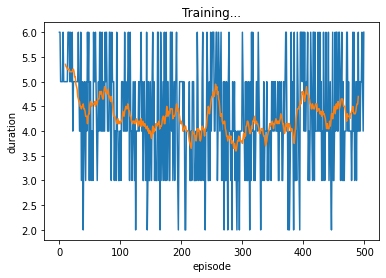

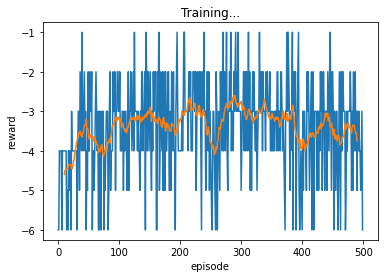

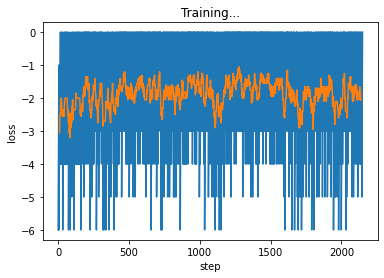

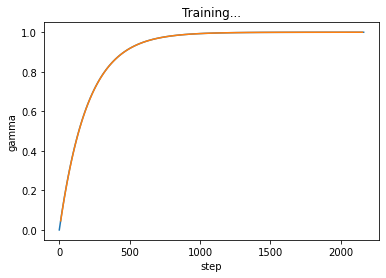

In [121]:
plot_all(*run_experiment(
    model=ModelConfig(name='avg_reward'),
    num_episodes=500,
    training=TrainConfig(optimizer='sgd', lr=0.01, batch_size=-1, train_interval=16, clear_memory=True),
    seed=1
    ))

monte weights
Parameter containing:
tensor([[0.0611, 0.2246],
        [0.2343, 0.1771],
        [0.5561, 0.1094],
        [0.4609, 0.7084],
        [0.5798, 0.4967],
        [0.5104, 0.3295]], dtype=torch.float64, requires_grad=True)
tensor([[0.4592, 0.5408],
        [0.5143, 0.4857],
        [0.6098, 0.3902],
        [0.4385, 0.5615],
        [0.5208, 0.4792],
        [0.5451, 0.4549]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 gaudy-------
reward -1 done False action 0
------guess 2 0 balmy-------
reward -1 done False action 0
------guess 3 0 happy-------
reward -1 done False action 0
------guess 4 1 snick-------
reward -1 done False action 1
------guess 5 0 fanny-------
reward -1 done True action 0
episode 0 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
optimize_model_batch -1 6
monte weights
Param

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 epoxy-------
reward 0 done True action 0
episode 15 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.3195493637954123  steps 78  memory 69
=========================episode 16 heath======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 heath-------
reward 0 done True action 0
episode 16 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.3296799539643607  steps 81  memory 72
optimize_model_batch -1 75
monte weights
Parameter containing:
tensor([[0.1260, 0.1596],
        [0.1416, 0.2697],
        [0.5420, 0.1236],
        [0.4810, 0.6883],
        [0.7790, 0.2974],
        [0.5781, 0.2618]], dtype=torch.float64, requires_grad=True)
tensor([[0.4916, 0.5084],
        [0.4680, 0.5320],
        [0.6031, 0.3969],
        [0.4484, 0.5516],
        [0.6181, 0.

monte weights
Parameter containing:
tensor([[0.0271, 0.2585],
        [0.1702, 0.2411],
        [0.6492, 0.0163],
        [0.6226, 0.5466],
        [0.8713, 0.2051],
        [0.6044, 0.2355]], dtype=torch.float64, requires_grad=True)
tensor([[0.4424, 0.5576],
        [0.4823, 0.5177],
        [0.6531, 0.3469],
        [0.5190, 0.4810],
        [0.6607, 0.3393],
        [0.5912, 0.4088]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
{'count': 18, 'total': -69, 'avg': -3.8333333333333335} {'count': 15, 'total': -60, 'avg': -4.0}
{'count': 16, 'total': -54, 'avg': -3.375} {'count': 17, 'total': -42, 'avg': -2.4705882352941178}
{'count': 20, 'total': -34, 'avg': -1.7} {'count': 13, 'total': -29, 'avg': -2.230769230769231}
{'count': 12, 'total': -9, 'avg': -0.75} {'count': 16, 'total': -26, 'avg': -1.625}
{'count': 11, 'total': 0, 'avg': 0.0} {'count': 10, 'total': -14, 'avg': -1.4}
{'count': 7, 'total': -1, 'avg': -0.14285714285714285} {'count': 3, 'total': -3, 'avg': -1.0}
done 158 opt

------guess 2 1 ducky-------
reward -1 done False action 1
------guess 3 0 avail-------
reward 0 done True action 0
episode 49 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.6942538205012883  steps 238  memory 0
=========================episode 50 fishy======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 pupil-------
reward -1 done False action 0
------guess 2 0 icing-------
reward -1 done False action 0
------guess 3 0 whiff-------
reward -1 done False action 0
------guess 4 0 fishy-------
reward 0 done True action 0
episode 50 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.7018027205701126  steps 243  memory 4
=========================episode 51 fried======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 drier-------
reward -1 done False action 0
------guess 2 0 fried-------
reward 0 done True action 0
episode 51 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7062422996764672  steps

reward -1 done False action 1
------guess 3 0 minty-------
reward 0 done True action 0
episode 67 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7898639287992353  steps 313  memory 7
=========================episode 68 sugar======================
------guess 0 0 gruff-------
reward -1 done False action 0
------guess 1 1 stoae-------
reward -1 done False action 1
------guess 2 0 sugar-------
reward 0 done True action 0
episode 68 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7929924473188473  steps 316  memory 11
=========================episode 69 tacky======================
------guess 0 0 atoll-------
reward -1 done False action 0
------guess 1 1 risen-------
reward -1 done False action 1
------guess 2 0 tacky-------
reward 0 done True action 0
episode 69 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7960743882657866  steps 319  memory 14
=========================episode 70 flown======================
------guess 0 0 smear-------
reward -1 done False action 0
------g

------guess 5 1 vozhd-------
reward -1 done True action 1
episode 85 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.856296050222297  steps 389  memory 12
=========================episode 86 tempo======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 depot-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 0 tempo-------
reward 0 done True action 0
episode 86 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8591415790789549  steps 393  memory 18
=========================episode 87 focal======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 zonal-------
reward -1 done False action 0
------guess 2 1 scudi-------
reward -1 done False action 1
------guess 3 1 lymph-------
reward -1 done False action 1
------guess 4 1 befog-------
reward -1 done False action 1
------guess 5 0 focal-------
reward 0 done True action 0
episode 87 finished.  rew

------guess 1 0 mouse-------
reward -1 done False action 0
------guess 2 0 gecko-------
reward -1 done False action 0
------guess 3 1 lindy-------
reward -1 done False action 1
------guess 4 1 bumph-------
reward -1 done False action 1
------guess 5 0 below-------
reward 0 done True action 0
episode 102 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9031895174735398  steps 468  memory 23
=========================episode 103 peril======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 hyper-------
reward -1 done False action 0
------guess 2 1 linds-------
reward -1 done False action 1
------guess 3 0 peril-------
reward 0 done True action 0
episode 103 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9051064934653769  steps 472  memory 29
=========================episode 104 trail======================
------guess 0 0 shine-------
reward -1 done False action 0
------guess 1 1 tolar-------
reward -1 done False action 1
------guess 2 0 tra

------guess 1 1 raile-------
reward -1 done False action 1
------guess 2 1 scand-------
reward -1 done False action 1
------guess 3 0 mural-------
reward 0 done True action 0
episode 119 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9327944872602503  steps 541  memory 25
=========================episode 120 until======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 unlit-------
reward -1 done False action 0
------guess 3 0 until-------
reward 0 done True action 0
episode 120 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9341252455735971  steps 545  memory 29
=========================episode 121 waxen======================
------guess 0 0 wispy-------
reward -1 done False action 0
------guess 1 0 wafer-------
reward -1 done False action 0
------guess 2 1 clout-------
reward -1 done False action 1
------guess 3 1 bundh-------
reward -1 done False action 1
------guess 4 0 wax

------guess 2 0 chaos-------
reward 0 done True action 0
episode 137 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.952641075608859  steps 611  memory 31
=========================episode 138 brute======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 exert-------
reward -1 done False action 0
------guess 3 0 brute-------
reward 0 done True action 0
episode 138 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9535788451425687  steps 615  memory 34
=========================episode 139 suite======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 elect-------
reward -1 done False action 0
------guess 2 1 nidus-------
reward -1 done False action 1
------guess 3 0 suite-------
reward 0 done True action 0
episode 139 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9544980455953784  steps 619  memory 38
=========================episode 140 

------guess 2 0 troll-------
reward -1 done False action 0
------guess 3 0 eject-------
reward -1 done False action 0
------guess 4 1 humid-------
reward -1 done False action 1
------guess 5 0 white-------
reward 0 done True action 0
episode 153 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9685702379816323  steps 693  memory 43
=========================episode 154 harsh======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 viral-------
reward -1 done False action 0
------guess 2 0 karma-------
reward -1 done False action 0
------guess 3 1 synch-------
reward -1 done False action 1
------guess 4 0 harsh-------
reward 0 done True action 0
episode 154 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9693462415707943  steps 698  memory 49
=========================episode 155 barge======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 bar

------guess 1 1 aloes-------
reward -1 done False action 1
------guess 2 0 missy-------
reward -1 done False action 0
------guess 3 0 spiky-------
reward -1 done False action 0
------guess 4 0 spicy-------
reward -1 done False action 0
------guess 5 0 spiny-------
reward 0 done True action 0
episode 171 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9787202635616228  steps 771  memory 48
=========================episode 172 wrong======================
------guess 0 0 piece-------
reward -1 done False action 0
------guess 1 0 worry-------
reward -1 done False action 0
------guess 2 0 wrong-------
reward 0 done True action 0
episode 172 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9790370775629483  steps 774  memory 54
=========================episode 173 riper======================
------guess 0 0 moody-------
reward -1 done False action 0
------guess 1 1 alter-------
reward -1 done False action 1
------guess 2 0 giver-------
reward -1 done False action 0
------guess 3 0 pip

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 unlit-------
reward -1 done False action 0
------guess 2 0 stint-------
reward 0 done True action 0
episode 189 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9850044231795223  steps 841  memory 46
=========================episode 190 adore======================
------guess 0 0 write-------
reward -1 done False action 0
------guess 1 1 sloan-------
reward -1 done False action 1
------guess 2 0 adore-------
reward 0 done True action 0
episode 190 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9852276782329125  steps 844  memory 49
=========================episode 191 groin======================
------guess 0 0 ether-------
reward -1 done False action 0
------guess 1 0 broad-------
reward -1 done False action 0
------guess 2 0 proof-------
reward -1 done False action 0
------guess 3 1 lysin-------
reward -1 done False action 1
------guess 4 0 groin-------
reward 0 done True action 0
episode 191 finished.

------guess 4 0 spook-------
reward 0 done True action 0
episode 207 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9896420402823863  steps 915  memory 56
=========================episode 208 surge======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 sperm-------
reward -1 done False action 0
------guess 3 0 surge-------
reward 0 done True action 0
episode 208 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9898471416266302  steps 919  memory 61
optimize_model_batch -1 65
monte weights
Parameter containing:
tensor([[ 0.2426,  0.0430],
        [ 0.4624, -0.0511],
        [ 1.1138, -0.4483],
        [ 1.4411, -0.2718],
        [ 1.4476, -0.3712],
        [ 1.0602, -0.2203]], dtype=torch.float64, requires_grad=True)
tensor([[0.5497, 0.4503],
        [0.6256, 0.3744],
        [0.8266, 0.1734],
        [0.8472, 0.1528],
        [0.8604, 0.1396],
        [0.7825, 0.2175]], dtype=to

------guess 2 0 synod-------
reward 0 done True action 0
episode 226 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9927734967186236  steps 987  memory 3
=========================episode 227 slick======================
------guess 0 0 foyer-------
reward -1 done False action 0
------guess 1 0 spunk-------
reward -1 done False action 0
------guess 2 0 smack-------
reward -1 done False action 0
------guess 3 0 slick-------
reward 0 done True action 0
episode 227 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9929165910709479  steps 991  memory 6
=========================episode 228 condo======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 folly-------
reward -1 done False action 0
------guess 2 0 bound-------
reward -1 done False action 0
------guess 3 1 chips-------
reward -1 done False action 1
------guess 4 0 condo-------
reward 0 done True action 0
episode 228 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9930914810605455  

------guess 1 1 ocrea-------
reward -1 done False action 1
------guess 2 1 dungy-------
reward -1 done False action 1
------guess 3 0 diode-------
reward 0 done True action 0
episode 244 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9951072462747605  steps 1065  memory 12
=========================episode 245 tight======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 might-------
reward -1 done False action 0
------guess 3 0 tight-------
reward 0 done True action 0
episode 245 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9952041292897036  steps 1069  memory 16
=========================episode 246 whoop======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 buxom-------
reward -1 done False action 0
------guess 3 1 chowk-------
reward -1 done False action 1
------guess 4 0 w

------guess 2 0 sloth-------
reward 0 done True action 0
episode 262 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9965521347238969  steps 1135  memory 19
=========================episode 263 title======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 utile-------
reward -1 done False action 0
------guess 3 0 title-------
reward 0 done True action 0
episode 263 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9966204070306233  steps 1139  memory 22
=========================episode 264 renew======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 riper-------
reward -1 done False action 0
------guess 2 0 rebel-------
reward -1 done False action 0
------guess 3 0 renew-------
reward 0 done True action 0
episode 264 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9966873274551001  steps 1143  memory 26
=========================episode 

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 fanny-------
reward -1 done False action 0
------guess 2 0 sigma-------
reward -1 done False action 0
------guess 3 0 axial-------
reward 0 done True action 0
episode 280 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9976538978793279  steps 1212  memory 28
=========================episode 281 shone======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 gouge-------
reward -1 done False action 0
------guess 2 0 whose-------
reward -1 done False action 0
------guess 3 0 shove-------
reward -1 done False action 0
------guess 4 0 shone-------
reward 0 done True action 0
episode 281 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9977118233470779  steps 1217  memory 32
=========================episode 282 ranch======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 r

------guess 1 0 perky-------
reward -1 done False action 0
------guess 2 0 truck-------
reward -1 done False action 0
------guess 3 0 brook-------
reward 0 done True action 0
episode 298 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9984035933193878  steps 1289  memory 38
=========================episode 299 cheat======================
------guess 0 0 coupe-------
reward -1 done False action 0
------guess 1 1 liart-------
reward -1 done False action 1
------guess 2 0 cadet-------
reward -1 done False action 0
------guess 3 0 cheat-------
reward 0 done True action 0
episode 299 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9984352042896059  steps 1293  memory 42
=========================episode 300 shrew======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 infer-------
reward -1 done False action 0
------guess 2 0 rebel-------
reward -1 done False action 0
------guess 3 0 screw-------
reward -1 done False action 0
------guess 4 1 d

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 tally-------
reward -1 done False action 0
------guess 2 0 antic-------
reward -1 done False action 0
------guess 3 0 admit-------
reward 0 done True action 0
episode 315 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9988917798288798  steps 1362  memory 44
=========================episode 316 soapy======================
------guess 0 0 tweet-------
reward -1 done False action 0
------guess 1 0 dryly-------
reward -1 done False action 0
------guess 2 0 gassy-------
reward -1 done False action 0
------guess 3 0 soapy-------
reward 0 done True action 0
episode 316 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9989137240585362  steps 1366  memory 48
=========================episode 317 valid======================
------guess 0 0 nadir-------
reward -1 done False action 0
------guess 1 1 toles-------
reward -1 done False action 1
------guess 2 0 valid-------
reward 0 done True action 0
episode 317 finishe

------guess 3 0 dusty-------
reward 0 done True action 0
episode 332 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999215135918689  steps 1431  memory 46
=========================episode 333 peach======================
------guess 0 0 rapid-------
reward -1 done False action 0
------guess 1 1 stole-------
reward -1 done False action 1
------guess 2 0 peach-------
reward 0 done True action 0
episode 333 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999226821022535  steps 1434  memory 50
=========================episode 334 ripen======================
------guess 0 0 loose-------
reward -1 done False action 0
------guess 1 0 udder-------
reward -1 done False action 0
------guess 2 0 grief-------
reward -1 done False action 0
------guess 3 0 rivet-------
reward -1 done False action 0
------guess 4 0 ripen-------
reward 0 done True action 0
episode 334 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9992459108795064  steps 1439  memory 53
=========================episode 33

------guess 3 0 flint-------
reward -1 done False action 0
------guess 4 0 midst-------
reward -1 done False action 0
------guess 5 0 visit-------
reward 0 done True action 0
episode 352 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9994605713316068  steps 1506  memory 53
optimize_model_batch -1 59
monte weights
Parameter containing:
tensor([[ 0.5075, -0.2218],
        [ 0.0209,  0.3905],
        [ 1.3395, -0.6740],
        [ 1.8964, -0.7271],
        [ 1.5087, -0.4323],
        [ 1.1061, -0.2661]], dtype=torch.float64, requires_grad=True)
tensor([[0.6747, 0.3253],
        [0.4086, 0.5914],
        [0.8822, 0.1178],
        [0.9324, 0.0676],
        [0.8745, 0.1255],
        [0.7977, 0.2023]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
{'count': 180, 'total': -582, 'avg': -3.2333333333333334} {'count': 173, 'total': -586, 'avg': -3.38728323699422}
{'count': 191, 'total': -460, 'avg': -2.4083769633507854} {'count': 162, 'total': -355, 'avg': -2.191358024691358}
{'count': 262,

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 rusty-------
reward 0 done True action 0
episode 369 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9996063309593449  steps 1569  memory 0
=========================episode 370 trend======================
------guess 0 0 lowly-------
reward -1 done False action 0
------guess 1 1 retia-------
reward -1 done False action 1
------guess 2 1 dunsh-------
reward -1 done False action 1
------guess 3 0 trend-------
reward 0 done True action 0
episode 370 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999614126128628  steps 1573  memory 3
=========================episode 371 adult======================
------guess 0 0 abbot-------
reward -1 done False action 0
------guess 1 1 riels-------
reward -1 done False action 1
------guess 2 0 adult-------
reward 0 done True action 0
episode 371 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9996198710421306 

------guess 2 0 lapel-------
reward 0 done True action 0
episode 388 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997267162704229  steps 1642  memory 10
=========================episode 389 doubt======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 point-------
reward -1 done False action 0
------guess 2 0 moult-------
reward -1 done False action 0
------guess 3 0 joust-------
reward -1 done False action 0
------guess 4 0 doubt-------
reward 0 done True action 0
episode 389 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9997334636697474  steps 1647  memory 13
=========================episode 390 musty======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 unity-------
reward -1 done False action 0
------guess 2 0 musty-------
reward 0 done True action 0
episode 390 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997374318787302  steps 1650  memory 18
=========================episode 

------guess 1 1 roset-------
reward -1 done False action 1
------guess 2 0 angle-------
reward -1 done False action 0
------guess 3 0 vague-------
reward 0 done True action 0
episode 406 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998102873501882  steps 1715  memory 18
=========================episode 407 wider======================
------guess 0 0 gamut-------
reward -1 done False action 0
------guess 1 1 reoil-------
reward -1 done False action 1
------guess 2 0 cider-------
reward -1 done False action 0
------guess 3 0 wider-------
reward 0 done True action 0
episode 407 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998140439123449  steps 1719  memory 22
=========================episode 408 segue======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 nudge-------
reward -1 done False action 0
------guess 2 0 segue-------
reward 0 done True action 0
episode 408 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.99981681243780

------guess 1 1 rotal-------
reward -1 done False action 1
------guess 2 0 worth-------
reward -1 done False action 0
------guess 3 0 forth-------
reward 0 done True action 0
episode 424 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998663117552086  steps 1785  memory 27
=========================episode 425 quark======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 drama-------
reward -1 done False action 0
------guess 3 0 wharf-------
reward -1 done False action 0
------guess 4 0 quark-------
reward 0 done True action 0
episode 425 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998696125297333  steps 1790  memory 31
=========================episode 426 rowdy======================
------guess 0 0 slink-------
reward -1 done False action 0
------guess 1 0 poppy-------
reward -1 done False action 0
------guess 2 0 moody-------
reward -1 done False action 0
------guess 3 0 w

------guess 4 0 vapid-------
reward 0 done True action 0
episode 440 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999067288765351  steps 1857  memory 33
=========================episode 441 rodeo======================
------guess 0 0 parry-------
reward -1 done False action 0
------guess 1 1 toile-------
reward -1 done False action 1
------guess 2 0 homer-------
reward -1 done False action 0
------guess 3 0 rodeo-------
reward 0 done True action 0
episode 441 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999085757685219  steps 1861  memory 38
=========================episode 442 teach======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 teach-------
reward 0 done True action 0
episode 442 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999099368980018  steps 1864  memory 42
=========================episode 443 apnea======================
------guess 0 1 roate------

------guess 1 1 laers-------
reward -1 done False action 1
------guess 2 0 rotor-------
reward 0 done True action 0
episode 458 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999339434919713  steps 1926  memory 37
=========================episode 459 harsh======================
------guess 0 0 serve-------
reward -1 done False action 0
------guess 1 1 tonal-------
reward -1 done False action 1
------guess 2 0 marsh-------
reward -1 done False action 0
------guess 3 0 harsh-------
reward 0 done True action 0
episode 459 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999935251498467  steps 1930  memory 40
=========================episode 460 crush======================
------guess 0 0 idyll-------
reward -1 done False action 0
------guess 1 1 oater-------
reward -1 done False action 1
------guess 2 0 gruff-------
reward -1 done False action 0
------guess 3 0 crumb-------
reward -1 done False action 0
------guess 4 0 crush-------
reward 0 done True action 0
episode 460 finished

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 froze-------
reward -1 done False action 0
------guess 2 0 prone-------
reward -1 done False action 0
------guess 3 0 erode-------
reward -1 done False action 0
------guess 4 0 broke-------
reward 0 done True action 0
episode 476 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999543725021426  steps 2000  memory 44
=========================episode 477 basal======================
------guess 0 0 quirk-------
reward -1 done False action 0
------guess 1 0 gnash-------
reward -1 done False action 0
------guess 2 0 salve-------
reward -1 done False action 0
------guess 3 0 basal-------
reward 0 done True action 0
episode 477 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999552759871339  steps 2004  memory 49
=========================episode 478 quail======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 a

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 nudge-------
reward -1 done False action 0
------guess 3 0 penne-------
reward -1 done False action 0
------guess 4 0 pence-------
reward 0 done True action 0
episode 494 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999687971150164  steps 2076  memory 54
=========================episode 495 sandy======================
------guess 0 0 arson-------
reward -1 done False action 0
------guess 1 1 telic-------
reward -1 done False action 1
------guess 2 0 spank-------
reward -1 done False action 0
------guess 3 0 sandy-------
reward 0 done True action 0
episode 495 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999694149735358  steps 2080  memory 59
=========================episode 496 bride======================
------guess 0 0 fizzy-------
reward -1 done False action 0
------guess 1 1 roate-------
reward -1 done False action 1
------guess 2 0 b

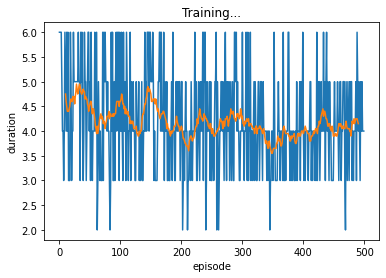

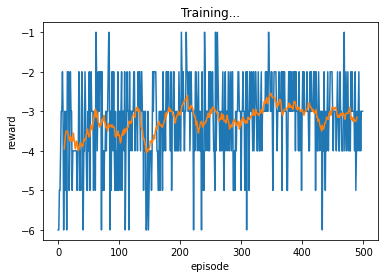

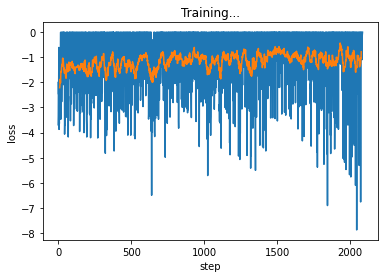

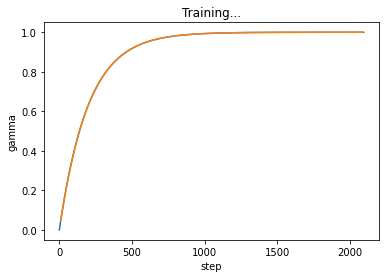

In [128]:
plot_all(*run_experiment(
    model=ModelConfig(name='monte'),
    num_episodes=500,
    training=TrainConfig(optimizer='adam', lr=0.01, batch_size=-1, train_interval=16, clear_memory=True),
    seed=1
    ))

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=150,
    training=TrainConfig(optimizer='adam', lr=0.009, batch_size=32, train_interval=32, clear_memory=True)
    ))

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=300,
    training=TrainConfig(optimizer='adam', lr=0.03, batch_size=64, train_interval=64, clear_memory=True)
    ))